# Lab Seven: RNNs

### Maria Harrison, Garrett Webb, Jackson Heck

## 1. Preparation

[2 points] Define and prepare your data set. Provide details about the source of the data. Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  Also discuss your rationale for the size and nature of your vocabulary.

We chose a small subset of a dataset of book reviews from the Amazon Kindle Store. The dataset contains 12,000 samples. Each sample contains a rating and the review text of the product. We will be performing sentiment analysis (many-to-one).

Dataset source: https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis

In [67]:
import numpy as np
import pandas as pd

# load dataset
df = pd.read_csv('/Users/marycateharrison/Library/Mobile Documents/com~apple~CloudDocs/SMU/spring-2023/machine-learning/preprocessed_kindle_review .csv')
# view sample of dataset
df.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [68]:
# rename columns
df = df.drop(columns=['Unnamed: 0', 'summary'])
df.head()

,rating,reviewText
0,5,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,5,I just had to edit this review. This book is a...
3,5,I don't normally buy 'mystery' novels because ...
4,5,"This isn't the kind of book I normally read, a..."


In [69]:
# pos = 1, neg = 0
df['rating'] = df['rating'].replace(to_replace=[1, 2, 3, 4, 5],value=[0, 0, 0, 1, 1])

In [83]:
print(df['rating'].value_counts()[0])
print(df['rating'].value_counts()[1])

6000
6000


Next, I wanted to visualize the general word count of all the papers.

In [75]:
text_numpy = df.reviewText.to_numpy()

num_less_than_50 = 0
num_less_than_100 = 0
num_less_than_500 = 0
num_less_than_1k = 0
num_less_than_2k = 0

for i in text_numpy:
    if(len(i.split()) < 50):
        num_less_than_50 +=1
    elif(len(i.split()) < 100):
        num_less_than_100 +=1
    elif(len(i.split()) < 500):
        num_less_than_500 +=1
    elif(len(i.split()) < 1000):
        num_less_than_1k += 1
    elif(len(i.split()) < 2000):
        num_less_than_2k += 1
        
print(num_less_than_50, num_less_than_100, num_less_than_500, num_less_than_1k, num_less_than_2k)

5020 2908 3834 226 11


It appears that most of the reviews are in the range of 0 to 500 words.

Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  

In [80]:
%%time
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df.reviewText.to_numpy()
y = df['rating'].to_numpy()

NUM_TOP_WORDS = None
MAX_ART_LEN = 500 # max and min num of words

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

NUM_CLASSES = 2

y_ohe = keras.utils.to_categorical(y, NUM_CLASSES)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 33056 unique tokens. Distilled to 33056 top words.
Shape of data tensor: (12000, 500)
Shape of label tensor: (12000, 2)
33056
CPU times: user 1.35 s, sys: 31.1 ms, total: 1.38 s
Wall time: 1.4 s


[0.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[0.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice.

X_train Shape: (9600, 500) Label Shape: (9600, 2)


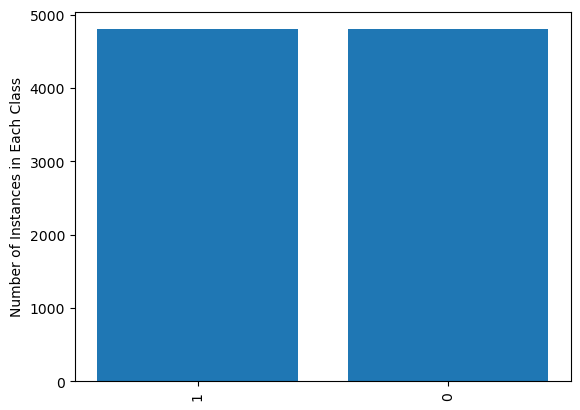

In [81]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=y)

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.bar(list(range(2)),uniq_classes)
plt.xticks(list(range(2)), class_labels, rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

## 2. Modeling

[2 points] Investigate at least two different recurrent network architectures  Be sure to use an embedding layer . Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them. Justify your choice of parameters for each.

In [85]:
%%time
EMBED_SIZE = 200
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('/Users/marycateharrison/Library/Mobile Documents/com~apple~CloudDocs/SMU/spring-2023/machine-learning/glove.6B/glove.6B.200d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])


Found 400000 word vectors.
Embedding Shape: (33057, 200) 
 Total words found: 26163 
 Percentage: 79.14511298665941
CPU times: user 12.1 s, sys: 479 ms, total: 12.6 s
Wall time: 12.7 s


In [92]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [97]:
def plot_history(history):
    # summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [93]:
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lstm = Sequential()
lstm.add(embedding_layer)
lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=.2))
lstm.add(Dense(NUM_CLASSES, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

gru = Sequential()
gru.add(embedding_layer)
gru.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gru.add(Dense(NUM_CLASSES, activation='sigmoid'))
gru.compile(loss='binary_crossentropy', 
              optimizer= 'rmsprop', 
              metrics=['accuracy'])

In [ ]:
history_lstm = []
tmp = lstm.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=6, batch_size=64)
history_lstm.append(tmp)

In [ ]:
history_gru = []
tmp = gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=6, batch_size=64)
history_gru.append(tmp)

In [ ]:
lstm_2 = Sequential()
lstm_2.add(embedding_layer)
lstm_2.add(LSTM(100, dropout=0.2, recurrent_dropout=.2))
lstm_2.add(Dense(NUM_CLASSES, activation='relu'))
lstm_2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

gru_2 = Sequential()
gru_2.add(embedding_layer)
gru_2.add(GRU(100, dropout=0.2, recurrent_dropout=0.2))
gru_2.add(Dense(NUM_CLASSES, activation='relu'))
gru_2.compile(loss='binary_crossentropy', 
              optimizer= 'adam', 
              metrics=['accuracy'])

In [ ]:
history_lstm_2 = []
tmp = lstm_2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=6, batch_size=64)
history_lstm_2.append(tmp)

In [ ]:
history_gru_2 = []
tmp = gru_2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=6, batch_size=64)
history_gru_2.append(tmp)

[1 points] Using the best parameters and architecture from the RNN in the previous step, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

In [ ]:
# let's extend the training by a number of epochs
tmp = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=6, batch_size=64)
history.append( tmp )

[0.5 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab.

[0.5 points] Run to convergence

In [ ]:
# combine all the history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in history])

[1 point]  Visualize the results of all the RNNs you trained.  

## 3. Additional Analysis